In [2]:
import os, folium, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio.v3 as iio
import geopandas as gpd
from IPython.display import Image, display
import tensorflow as tf
%matplotlib inline

2023-05-23 03:21:20.789427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 03:21:20.903739: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 03:21:21.843777: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2023-05-23 03:21:21.843916: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2023-05-23 03:21:21.854541: I tensorflow/c/logging.cc:34] Successfully opened dynamic l

In [3]:
from tensorflow.keras import layers, callbacks, backend, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [26]:
labels= gpd.read_file('labels.geojson')
labels.head(2)

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,6,42.033642,-97.719996,Negative,"White Spec (Seadoo, pivot irrigation, etc.)",train_images/42.03364226519898_-97.7199955063882,"POLYGON ((-97.71676 42.03605, -97.71676 42.031..."


In [27]:
labels_unique = labels[(labels.Type == 'Negative') | (labels.Type == 'CAFOs') | (labels.Type == 'WWTreatment')
           | (labels.Type == 'Landfills') | (labels.Type == 'RefineriesAndTerminals')
           | (labels.Type == 'ProcessingPlants') | (labels.Type == 'Mines')]

In [109]:
X = []
for im_path in labels_unique.Image_Folder.values:
     X.append(iio.imread(f'{im_path}/naip.png'))

FileNotFoundError: No such file: '/root/code/dvictoria2/methane_source/train_images/43.00443446102501_-78.20890003579709/naip.png/naip.png'

In [7]:
X[0].shape

NameError: name 'X' is not defined

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels_unique.Type.values.reshape(labels_unique.Type.values.shape[0], 1))
mlb.classes_
y.shape

In [ ]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.7, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.5, stratify=y_rest)


In [ ]:
X_train = np.array(X_train)

In [ ]:
type(X_train)

In [ ]:
X_val = np.array(X_val)

In [ ]:
y_tra_orig = np.argwhere(y_train == 1.0)[:,1]
y_res_orig = np.argwhere(y_rest == 1.0)[:,1]

In [ ]:
def invert_ecoding(encoded_labels, categories):
    categories = ['[unk]']+categories
    return np.take(categories, np.argwhere(encoded_labels == 1.0)[:,1])

In [ ]:
def build_model():
    i = layers.Input(shape=(720,720, 3), dtype = tf.float32)
    i1 = layers.Resizing(
        224,
        224,
        interpolation='bilinear',
        crop_to_aspect_ratio=False
    )(i)
    out = tf.keras.applications.EfficientNetB0(include_top=True,
                      weights='imagenet'
                      )(i1)
    out = layers.Dense(32, activation='relu')(out)
    out = layers.Dense(7, activation='sigmoid')(out)
    model = Model(inputs=i, outputs=out)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.models import Model

#i = layers.Input(shape=(720,720, 4), dtype = tf.float32)
#i1 = layers.Resizing(
#        224,
#        224,
#        interpolation='bilinear',
#        crop_to_aspect_ratio=False
#)(i)

efficientnet_model = EfficientNetB0(include_top=False, weights=None, input_shape=(720,720, 4))
efficientnet_output = efficientnet_model.layers[-1].output

flatten_layer = Flatten()(efficientnet_output)

dense_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(7, activation='sigmoid')(dense_layer)

#model = Model(inputs=efficientnet_model.input, outputs=output_layer)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/root/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/keras/applications/efficientnet.py:321: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
2023-05-23 03:21:40.694763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 03:21:40.696047: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA RTX A4000 Laptop GPU)
2023-05-23 03:21:43.034061: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 1 (Intel(R) UHD Graphics)
2023-05-23 03:21:43.063630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc

In [ ]:
model=build_model()
cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3)]
epochs = 10
batch_size = 4

history = model.fit(X_train,
         y_train,
         epochs=epochs,
         batch_size=batch_size,
         callbacks=cb,
         validation_data=(X_val, y_val))

In [ ]:
!git add efficient_net.ipynb
!git commit -m 'first model'


In [28]:
from keras.preprocessing import image
dir_path=r"/root/code/dvictoria2/methane_source/"
datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.1)

In [29]:
labels_unique

,id,Latitude,Longitude,Type,Source,Image_Folder,geometry
0,1,43.004434,-78.208900,Negative,Aeroplanes,train_images/43.00443446102501_-78.20890003579709,"POLYGON ((-78.20567 43.00681, -78.20567 43.002..."
1,6,42.033642,-97.719996,Negative,"White Spec (Seadoo, pivot irrigation, etc.)",train_images/42.03364226519898_-97.7199955063882,"POLYGON ((-97.71676 42.03605, -97.71676 42.031..."
2,9,34.495000,-97.118000,WWTreatment,HydroWASTE,train_images/34.495_-97.118,"POLYGON ((-97.11477 34.49768, -97.11477 34.492..."
3,12,38.381380,-75.401000,CAFOs,DataForCauseChallenge,train_images/38.38138_-75.401,"POLYGON ((-75.39777 38.38393, -75.39777 38.378..."
4,17,45.647973,-84.469159,RefineriesAndTerminals,EIA-HIFLD,train_images/45.647973_-84.469159,"POLYGON ((-84.46593 45.65024, -84.46593 45.645..."
...,...,...,...,...,...,...,...
14182,84941,35.852756,-101.538265,Negative,Windmills,train_images/35.85275555452138_-101.5382646083...,"POLYGON ((-101.53503 35.85539, -101.53503 35.8..."
14183,85008,47.186826,-122.436115,Negative,Roundabout,train_images/47.18682636726484_-122.4361145478...,"POLYGON ((-122.43288 47.18903, -122.43288 47.1..."
14184,85035,42.703517,-83.303270,Negative,Parking Lots,train_images/42.703517482995565_-83.3032698788...,"POLYGON ((-83.30004 42.70590, -83.30004 42.701..."
14185,85048,34.159700,-86.468760,CAFOs,DataForCauseChallenge,train_images/34.1597_-86.46876,"POLYGON ((-86.46553 34.16239, -86.46553 34.157..."


In [31]:
#labels_unique.Image_Folder=labels_unique.Image_Folder+"/naip.png"

/root/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
iio.imread(fp)

In [110]:
train_generator=datagen.flow_from_dataframe(
    dataframe=labels_unique, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=64, subset = "training", color_mode='rgba')

Found 12714 validated image filenames belonging to 7 classes.


In [112]:
X, y = train_generator.next()

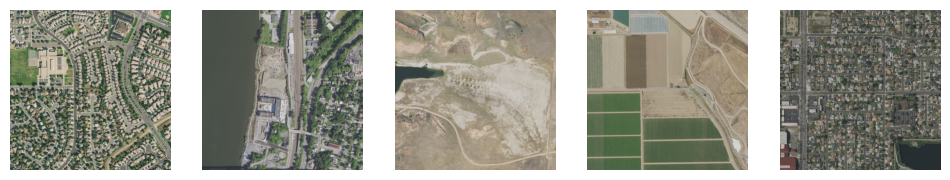

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):
    axs[i].imshow(X[i])
    axs[i].axis('off')

plt.show()

In [113]:
X.shape


(64, 720, 720, 4)

In [111]:
validation_generator = datagen.flow_from_dataframe(dataframe=labels_unique, directory=dir_path, 
    x_col="Image_Folder", y_col="Type", seed = 42,
    class_mode="categorical", target_size=(720,720), batch_size=64, subset = "validation", color_mode='rgba')

Found 1412 validated image filenames belonging to 7 classes.


In [114]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [51]:

efficientnet_model = EfficientNetB0(include_top=False, weights=None, input_shape=((224,224,4)))
efficientnet_output = efficientnet_model.layers[-1].output

flatten_layer = Flatten()(efficientnet_output)

dense_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(7, activation='sigmoid')(dense_layer)

model = Model(inputs=efficientnet_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [121]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.models import Model

def build_model():
    i = layers.Input(shape=(720, 720, 4), dtype=tf.float32)
    i1 = layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False)(i)
    i2 = layers.Rescaling(1./255)(i1)
    d = layers.Conv2D(3, (1, 1))(i2)
    out = DenseNet121(include_top=False, weights='imagenet')(d)
    out0=layers.Flatten()(out)
    out2 = layers.Dense(32, activation='relu')(out0)
    out3 = layers.Dense(7, activation='sigmoid')(out2)
    model = Model(inputs=i, outputs=out3)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [90]:
y.shape

(64, 7)

In [79]:
from tensorflow.keras import layers

class ChannelReductionLayer(layers.Layer):
    def __init__(self, num_output_channels, **kwargs):
        super(ChannelReductionLayer, self).__init__(**kwargs)
        self.num_output_channels = num_output_channels

    def build(self, input_shape):
        self.reduce_channels = self.add_weight(
            name="reduce_channels",
            shape=(1, 1, input_shape[-1], self.num_output_channels),
            initializer="ones",
            trainable=True
        )
        super(ChannelReductionLayer, self).build(input_shape)

    def call(self, inputs):
        return inputs * self.reduce_channels

def build_model():
    i = layers.Input(shape=(720, 720, 4), dtype=tf.float32)
    i1 = layers.Resizing(224, 224, interpolation='bilinear', crop_to_aspect_ratio=False)(i)
    i1 = layers.Rescaling(1./255)(i1)
    x = ChannelReductionLayer(3)(i1)  # Reducción de canales personalizada
    x = layers.Conv2D(3, (3, 3))(x)  # Capa Conv2D que produce la salida
    model = tf.keras.Model(inputs=i, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [122]:
backend.clear_session()
model = build_model()
model.layers[2].trainable=False
model.summary()


cb = [callbacks.EarlyStopping(patience=5), callbacks.ReduceLROnPlateau(patience=3),callbacks.ModelCheckpoint('methane_V1.hdf5', monitor='loss',verbose=1, save_best_only=True)]
epochs = 50
# fits the model on batches with real-time data augmentation:
history =model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10, callbacks = cb)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 720, 4)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 4)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       15        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                160566

/tmp/ipykernel_29176/624621830.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(generator=train_generator,


Epoch 1/10


2023-05-23 05:47:48.501643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-23 05:47:51.632824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 05:47:51.632878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 05:47:51.632907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-23 05:47:51.632922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

198/198 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2923         

2023-05-23 06:00:52.064193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-23 06:00:52.705300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 06:00:52.705350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 06:00:52.705375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 51939 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-05-23 06:00:52.705387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f


Epoch 1: loss did not improve from inf
198/198 [==============================] - 836s 4s/step - loss: nan - accuracy: 0.2923 - val_loss: nan - val_accuracy: 0.3139 - lr: 0.0010
Epoch 2/10
 27/198 [===>..........................] - ETA: 15:42 - loss: 0.0000e+00 - accuracy: 0.2344    